In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np

import random
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import math
from IPython import display

import os
from urllib.request import urlopen
import zipfile

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
# List the urls hosting the DigiFace dataset
dataset_urls = [
    'https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip',
    #'https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_2000-3999_72_imgs.zip'
]

In [ ]:
# Copy the DigiFace dataset into local workspace files
for idx, dataset_url in enumerate(dataset_urls):
    setname = 'DigiFaceP' + str(idx + 1)

    if not os.path.exists(setname + '.zip'):
        with urlopen(dataset_url) as file:
            content = file.read()
            file.close()

        with open(setname + '.zip', 'wb') as download:
            download.write(content)
            download.close()

    with zipfile.ZipFile(setname + '.zip', 'r') as zip_file:
        zip_file.extractall('DigiFace')
        zip_file.close()

KeyboardInterrupt: 

In [ ]:
# Copy the DigiFace dataset into local workspace files
for idx, dataset_url in enumerate(dataset_urls):
    with zipfile.ZipFile(setname + '.zip', 'r') as zip_file:
        zip_file.extractall('DigiFace')
        zip_file.close()

In [ ]:
import shutil
import os
for i in range(16, 64):
    shutil.rmtree("DigiFace/" + str(i))

In [ ]:
import shutil
import os
for i in range(64, 2000):
    shutil.rmtree("DigiFace/" + str(i))

FileNotFoundError: [Errno 2] No such file or directory: 'DigiFace/64'

In [ ]:
# Load the DigiFace dataset into PyTorch DataLoaders
dataset = datasets.ImageFolder('DigiFace',
                   transform=transforms.Compose([
                       transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Resize(64)
                   ]))

subsets = torch.utils.data.random_split(dataset, [0.7, 0.3])

train_loader = torch.utils.data.DataLoader(subsets[0],
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(subsets[1],
    batch_size=1000, shuffle=True)

print(train_loader.dataset.__len__())
print(test_loader.dataset.__len__())

3226
1382


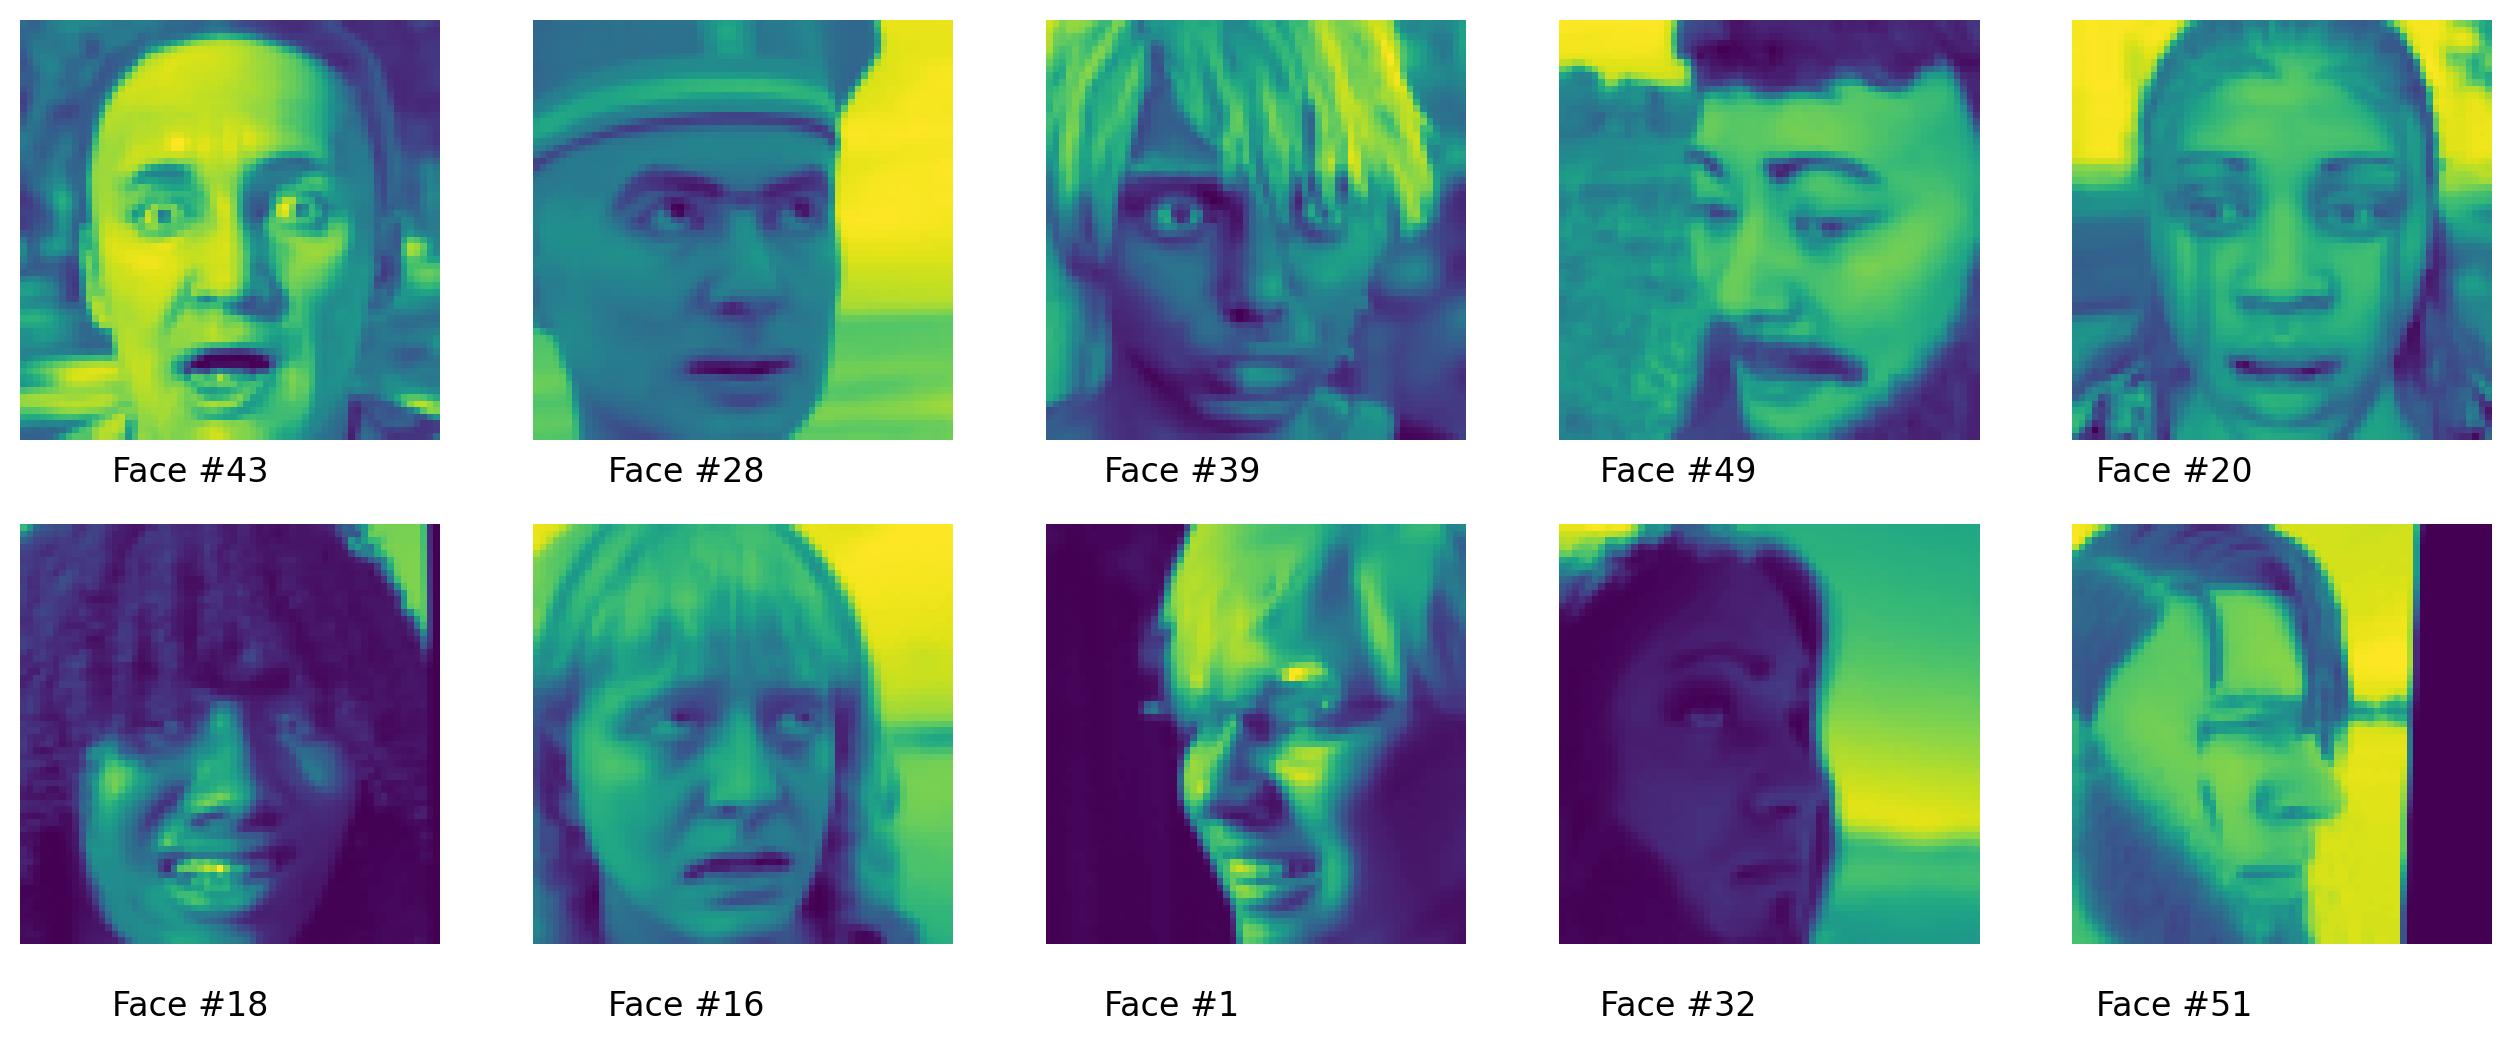

In [ ]:
# Plot 10 random images from the training set along with labels
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, label = train_loader.dataset.__getitem__(random.randrange(0, train_loader.dataset.__len__()))
    npimage = image.squeeze().numpy()
    plt.imshow(npimage)
    plt.figtext(0.155 * ((i+2) // 2), 0.445 * (i % 2) + 0.05, "Face #" + str(label), wrap=True, fontsize=12)
    plt.axis('off');

FCNN Model

In [ ]:
class FCNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCNN, self).__init__()

        self.fc1 = nn.Linear(input_size, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 64)
        self.fc3 = nn.Linear(64, output_size)

        nn.init.normal_(self.fc1.weight, std=0.001)
        nn.init.normal_(self.fc2.weight, std=0.001)
        nn.init.normal_(self.fc3.weight, std=0.001)

    def forward(self, x, target):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        self.fc = nn.Linear(10816, 64)
        self.fc2 = nn.Linear(64, output_size)
        nn.init.normal_(self.fc.weight, std=0.001)
        nn.init.normal_(self.fc2.weight, std=0.001)

    def forward(self, x, target):
        x = self.conv_layers(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

Deep CNN Model

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(DeepCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1),

            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding=1),

            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),

            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten()
        )

        self.fc = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, output_size)
        nn.init.normal_(self.fc.weight, std=0.001)
        nn.init.normal_(self.fc2.weight, std=0.001)

    def forward(self, x, target):
        x = self.conv_layers(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        #x = F.log_softmax(x, dim=1)
        return x

Transformer-Based Model

In [ ]:
class TransformerNN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(TransformerNN, self).__init__()
        self.network = models.vit_b_16()

    def forward(self, x, target):
        return self.network.forward(x, target)

Pre-Trained Models

Testing of Models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
input_size = 64*64                          # images are 64x64 pixels
output_size = 64 #2000 * len(dataset_urls)  # each dataset url has 2000 identities

In [ ]:
accuracy_list = []

def train(epochs, model, loss_function, optimizer, embeddings=None):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(train_loader):
          # send to device
          data, target = data.to(device), target.to(device)
          if embeddings is not None:
            data = embeddings(data, target).view(data.shape)

          optimizer.zero_grad()
          output = model(data, target)
          loss = loss_function(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % 100 == 0 and epoch % 10 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))

def test(model, loss_function, embeddings=None):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        if embeddings is not None:
            data = embeddings(data, target).view(data.shape)

        output = model(data, target)
        test_loss += loss_function(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
class Embedding(nn.Module):
    def __init__(self, input_size):
        super(Embedding, self).__init__()

        self.fc = nn.Linear(input_size, input_size)
        nn.init.normal_(self.fc.weight, std=0.001)

    def forward(self, x, target):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def train_embeddings(epochs, model, loss_function, optimizer):
    model.train()
    for epoch in range(epochs):
      for batch_idx, (data, target) in enumerate(train_loader):
          # send to device
          data, target = data.to(device), target.to(device)

          optimizer.zero_grad()
          output = model(data, target)

          anchors = torch.Tensor([]).to(device)
          positives = torch.Tensor([]).to(device)
          negatives = torch.Tensor([]).to(device)
          for i in range(len(output)):
            for j in range(len(output)):
                if i != j and target[i] == target[j]:
                    anchors = torch.cat((anchors, output[i]), 0)
                    positives =  torch.cat((positives, output[j]), 0)
                    r = random.randint(0, len(output)-1)
                    while i == r or target[i] == target[r]:
                        r = random.randint(0, len(output)-1)
                    negatives = torch.cat((negatives, output[r]), 0)
          loss = loss_function(anchors, positives, negatives)
          loss.backward()
          optimizer.step()
          if batch_idx % 100 == 0 and epoch % 10 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.item()))

def test_embeddings(model, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data, target)
        anchors = torch.Tensor([]).to(device)
        positives = torch.Tensor([]).to(device)
        negatives = torch.Tensor([]).to(device)
        for i in range(len(output)):
            for j in range(len(output)):
                if i != j and target[i] == target[j]:
                    anchors = torch.cat((anchors, output[i]), 0)
                    positives =  torch.cat((positives, output[j]), 0)
                    r = random.randint(0, len(output)-1)
                    while i == r or target[i] == target[r]:
                        r = random.randint(0, len(output)-1)
                    negatives = torch.cat((negatives, output[r]), 0)

        test_loss += loss_function(anchors, positives, negatives, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
'''
model_embeddings = Embedding(input_size)
if torch.cuda.is_available():
    model_fnn = torch.nn.DataParallel(model_embeddings).cuda()
model_embeddings.to(device)
optimizer = optim.Adam(model_embeddings.parameters())
loss_function = F.triplet_margin_loss
train_embeddings(epochs=5, model=model_embeddings, loss_function=loss_function, optimizer=optimizer)
test_embeddings(model_embeddings, loss_function)
'''

'\nmodel_embeddings = Embedding(input_size)\nif torch.cuda.is_available():\n    model_fnn = torch.nn.DataParallel(model_embeddings).cuda()\nmodel_embeddings.to(device)\noptimizer = optim.Adam(model_embeddings.parameters())\nloss_function = F.triplet_margin_loss\ntrain_embeddings(epochs=5, model=model_embeddings, loss_function=loss_function, optimizer=optimizer)\ntest_embeddings(model_embeddings, loss_function)\n'

Create lists of different testing parameters.

In [ ]:
loss_functions = [
    F.cross_entropy,
    F.nll_loss,
]

optimizers = [
    optim.Adam,
]

n_hidden = 8

Test of FCNN

In [ ]:
'''
model_fnn = FCNN(input_size, n_hidden, output_size)
for loss_function in loss_functions:
    if torch.cuda.is_available():
        model_fnn = torch.nn.DataParallel(model_fnn).cuda()
    model_fnn.to(device)

    for optimizer_function in optimizers:
        optimizer = optimizer_function(model_fnn.parameters())
        print("Using " + str(loss_function)[10:-19] + " and " + str(optimizer)[:str(optimizer).find('(')-1] + "\n")
        print('Number of parameters: {}'.format(get_n_params(model_fnn)))

        train(epochs=200, model=model_fnn, loss_function=loss_function, optimizer=optimizer)
        test(model_fnn, loss_function)
        print("\n\n")
'''

'\nmodel_fnn = FCNN(input_size, n_hidden, output_size)\nfor loss_function in loss_functions:\n    if torch.cuda.is_available():\n        model_fnn = torch.nn.DataParallel(model_fnn).cuda()\n    model_fnn.to(device)\n\n    for optimizer_function in optimizers:\n        optimizer = optimizer_function(model_fnn.parameters())\n        print("Using " + str(loss_function)[10:-19] + " and " + str(optimizer)[:str(optimizer).find(\'(\')-1] + "\n")\n        print(\'Number of parameters: {}\'.format(get_n_params(model_fnn)))\n\n        train(epochs=200, model=model_fnn, loss_function=loss_function, optimizer=optimizer)\n        test(model_fnn, loss_function)\n        print("\n\n")\n'

Test of CNN

In [ ]:
model_cnn = CNN(input_size, n_hidden, output_size)
for loss_function in loss_functions:
    if torch.cuda.is_available():
        model_cnn = torch.nn.DataParallel(model_cnn).cuda()
    model_cnn.to(device)

    for optimizer_function in optimizers:
        optimizer = optimizer_function(model_cnn.parameters())
        print("Using " + str(loss_function)[10:-19] + " and " + str(optimizer)[:str(optimizer).find('(')-1] + "\n")
        print('Number of parameters: {}'.format(get_n_params(model_cnn)))

        train(epochs=100, model=model_cnn, loss_function=loss_function, optimizer=optimizer)#, embeddings=model_embeddings)
        test(model_cnn, loss_function)#, embeddings=model_embeddings)
        print("\n\n")

Using cross_entropy and Adam

Number of parameters: 748544
Train Epoch: 0 [0/3226 (0%)]	Loss: 4.162768
Train Epoch: 10 [0/3226 (0%)]	Loss: 2.093184
Train Epoch: 20 [0/3226 (0%)]	Loss: 0.626020
Train Epoch: 30 [0/3226 (0%)]	Loss: 0.667874
Train Epoch: 40 [0/3226 (0%)]	Loss: 0.126457
Train Epoch: 50 [0/3226 (0%)]	Loss: 0.109388
Train Epoch: 60 [0/3226 (0%)]	Loss: 0.008343
Train Epoch: 70 [0/3226 (0%)]	Loss: 0.014403
Train Epoch: 80 [0/3226 (0%)]	Loss: 0.003749
Train Epoch: 90 [0/3226 (0%)]	Loss: 0.002313

Test set: Average loss: 6.8379, Accuracy: 735/1382 (53%)




Using nll_loss and Adam

Number of parameters: 748544
Train Epoch: 0 [0/3226 (0%)]	Loss: 0.000993
Train Epoch: 10 [0/3226 (0%)]	Loss: 0.001539
Train Epoch: 20 [0/3226 (0%)]	Loss: 0.000590
Train Epoch: 30 [0/3226 (0%)]	Loss: 0.000666
Train Epoch: 40 [0/3226 (0%)]	Loss: 0.000519
Train Epoch: 50 [0/3226 (0%)]	Loss: 0.000240
Train Epoch: 60 [0/3226 (0%)]	Loss: 0.000201
Train Epoch: 70 [0/3226 (0%)]	Loss: 0.000153
Train Epoch: 80 [

Test of Deep CNN

In [ ]:
'''
model_dcnn = DeepCNN(input_size, n_hidden, output_size)
for loss_function in loss_functions:
    if torch.cuda.is_available():
        model_dcnn = torch.nn.DataParallel(model_dcnn).cuda()
    model_dcnn.to(device)

    for optimizer_function in optimizers:
        optimizer = optimizer_function(model_dcnn.parameters())
        print("Using " + str(loss_function)[10:-19] + " and " + str(optimizer)[:str(optimizer).find('(')-1] + "\n")
        print('Number of parameters: {}'.format(get_n_params(model_dcnn)))

        train(epochs=100, model=model_dcnn, loss_function=loss_function, optimizer=optimizer)
        test(model_dcnn, loss_function)
        print("\n\n")
'''

'\nmodel_dcnn = DeepCNN(input_size, n_hidden, output_size)\nfor loss_function in loss_functions:\n    if torch.cuda.is_available():\n        model_dcnn = torch.nn.DataParallel(model_dcnn).cuda()\n    model_dcnn.to(device)\n\n    for optimizer_function in optimizers:\n        optimizer = optimizer_function(model_dcnn.parameters())\n        print("Using " + str(loss_function)[10:-19] + " and " + str(optimizer)[:str(optimizer).find(\'(\')-1] + "\n")\n        print(\'Number of parameters: {}\'.format(get_n_params(model_dcnn)))\n\n        train(epochs=100, model=model_dcnn, loss_function=loss_function, optimizer=optimizer)\n        test(model_dcnn, loss_function)\n        print("\n\n")\n'

Test of Transformer

In [ ]:
# import torch
# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torchvision.models as models
# from torch.utils.data import DataLoader, random_split


# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize to 224x224
#     transforms.Grayscale(),
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to 3-channel by repeating the single channel
# ])


# # Load datasets
# dataset = datasets.ImageFolder('DigiFace', transform=transform)

# # Split dataset into training and testing
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# # Load data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
# model_transformer.to(device)

# for loss_function in loss_functions:
#     if torch.cuda.is_available():
#         model_transformer = torch.nn.DataParallel(model_transformer).cuda()
#     else:
#         model_transformer.to(device)

#     for optimizer_function in optimizers:
#         optimizer = optimizer_function(model_transformer.parameters())
#         print("Using " + str(loss_function) + " and " + str(optimizer)[:str(optimizer).find('(')-1] + "\n")
#         print('Number of parameters: {}'.format(sum(p.numel() for p in model_transformer.parameters())))

#         train(epochs=10, model=model_transformer, loss_function=loss_function, optimizer=optimizer)
#         test(model_transformer, loss_function)
#         print("\n\n")



import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os

# Custom dataset for triplet loss
class TripletFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = datasets.ImageFolder(root_dir)
        self.classes = self.image_folder.classes
        self.class_to_idx = self.image_folder.class_to_idx

        self.image_paths = []
        self.labels = []

        for img_path, label in self.image_folder.samples:
            self.image_paths.append(img_path)
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor_label = self.labels[idx]

        positive_idx = idx
        while positive_idx == idx or self.labels[positive_idx] != anchor_label:
            positive_idx = torch.randint(len(self), (1,)).item()

        negative_idx = idx
        while self.labels[negative_idx] == anchor_label:
            negative_idx = torch.randint(len(self), (1,)).item()

        positive_path = self.image_paths[positive_idx]
        negative_path = self.image_paths[negative_idx]

        anchor = Image.open(anchor_path).convert('RGB')
        positive = Image.open(positive_path).convert('RGB')
        negative = Image.open(negative_path).convert('RGB')

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

# Define data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Convert grayscale to 3-channel by repeating the single channel
])

# Load the dataset
dataset = TripletFaceDataset('DigiFace', transform=transform)

# Split dataset into training and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Vision Transformer model for feature extraction
class TransformerNN(nn.Module):
    def __init__(self):
        super(TransformerNN, self).__init__()
        self.network = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.network.heads.head = nn.Identity()  # Remove the classification head

    def forward(self, x):
        embeddings = self.network(x)
        return embeddings

# Initialize the model
model_transformer = TransformerNN().to(device)

# If multiple GPUs are available, use DataParallel
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    model_transformer = nn.DataParallel(model_transformer)

# Define the loss function and optimizer
criterion = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(model_transformer.parameters(), lr=0.001)

# Define the training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for anchors, positives, negatives in train_loader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

            optimizer.zero_grad()

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)

            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train_model(model_transformer, train_loader, criterion, optimizer, num_epochs=20)
def test_model(model, test_loader, margin=1.0):
    model.eval()
    correct = 0
    total_triplets = 0
    with torch.no_grad():
        for anchors, positives, negatives in test_loader:
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)

            # Calculate distances
            pos_dist = F.pairwise_distance(anchor_embeddings, positive_embeddings, p=2)
            neg_dist = F.pairwise_distance(anchor_embeddings, negative_embeddings, p=2)

            # Count the number of correct triplets
            correct += (pos_dist < neg_dist).sum().item()
            total_triplets += anchors.size(0)

    accuracy = 100. * correct / total_triplets
    print(f'\nTest set: Accuracy: {correct}/{total_triplets} ({accuracy:.0f}%)\n')
    return accuracy

test_model(model_transformer, test_loader)



Epoch 1/20, Loss: 0.9780
Epoch 2/20, Loss: 0.9677
Epoch 3/20, Loss: 0.9600
Epoch 4/20, Loss: 0.9493
Epoch 5/20, Loss: 0.9705
Epoch 6/20, Loss: 0.9636
Epoch 7/20, Loss: 0.9546
Epoch 8/20, Loss: 0.9239
Epoch 9/20, Loss: 0.9301
Epoch 10/20, Loss: 0.9879
Epoch 11/20, Loss: 0.9653
Epoch 12/20, Loss: 0.9420
Epoch 13/20, Loss: 0.9664
Epoch 14/20, Loss: 0.9676
Epoch 15/20, Loss: 0.9707
Epoch 16/20, Loss: 0.9825
Epoch 17/20, Loss: 0.9424
Epoch 18/20, Loss: 0.9338
Epoch 19/20, Loss: 0.9188
Epoch 20/20, Loss: 0.9438

Test set: Accuracy: 132/231 (57%)



57.142857142857146

In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
from datasets import load_dataset
from transformers import AutoImageProcessor, Swinv2ForImageClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import random_split

dataset = load_dataset("nielsr/CelebA-faces")

train_size = int(0.9 * len(dataset['train']))
val_size = len(dataset['train']) - train_size
train_dataset, val_dataset = random_split(dataset['train'], [train_size, val_size])

image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")
model = Swinv2ForImageClassification.from_pretrained("microsoft/swinv2-tiny-patch4-window8-256")

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Compute metrics
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = (preds == p.label_ids).astype(float).mean()
    return {'accuracy': accuracy}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
results = trainer.evaluate(val_dataset)
print(results)

inputs = image_processor(image, return_tensors="pt")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`